# Optimierung – Besser geht’s nicht

Dieses Jupyter-Notebook enthält den Quelltext für Kapitel 9 »Optimierung – Besser geht’s nicht« im Buch [Python für Ingenieure für Dummies](https://python-fuer-ingenieure.de/).


In [1]:
# sorgt dafür, dass, wenn die letzte Zeile eine Zuweisung ist, deren Ergebnis auch ausgegeben wird
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("../util")
from pfi_util import define_plot_params, show_book, set_cmap_cycler

orig_plt_rcParams, double_plt_rcParams = define_plot_params(plt)
set_cmap_cycler(N=2)

### Einführungsbeispiel: Maximum-Power-Point eines Solarmoduls

`begin mpp_intro1`

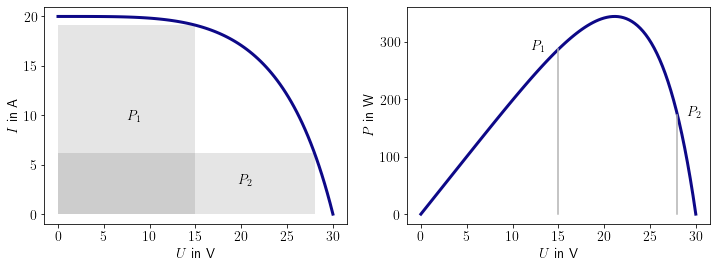

In [3]:
I0 = 20 # Kurzschlussstrom
U0 = 30 # Leerlaufspannung

def i_func(u):
    return (2-np.exp((u/U0)**4*np.log(2)))*I0

def p_func(u):
    return u*i_func(u)

uu = np.linspace(0, U0, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4));
ax1.plot(uu, i_func(uu), lw=3)
ax2.plot(uu, p_func(uu), lw=3)
# (Beschriftungscode ausgeblendet)
# #!
ax1.set_xlabel("$U$ in V") #!
ax1.set_ylabel("$I$ in A") #!
# #!
ax2.set_xlabel("$U$ in V") #!
ax2.set_ylabel("$P$ in W") #!
# #!
du1 = 15 #!
rect = plt.Rectangle((0, 0), du1, i_func(du1), facecolor="black", alpha=0.1)#!
ax1.add_patch(rect) #!
ax1.text(du1/2, i_func(du1)/2, "$P_1$") #!
##!
du2 = 28 #!
rect = plt.Rectangle((0, 0), du2, i_func(du2), facecolor="black", alpha=0.1)#!
ax1.add_patch(rect) #!
ax1.text(du2*0.7, i_func(du2)/2, "$P_2$") #!
# #!
ax2.plot([du1, du1], [0, p_func(du1)], color="0.7") #!
ax2.plot([du2, du2], [0, p_func(du2)], color="0.7") #!
ax2.text(du1-3, p_func(du1), "$P_1$") #!
ax2.text(du2+1, p_func(du2), "$P_2$") #!
show_book("pv-modul-iup") #!

`end mpp_intro1`

In [4]:
plt.rcParams.update(orig_plt_rcParams)

In [5]:
9/8*2.5

2.8125

In [6]:
# 72.27pt=1in = 2.54cm

pt_in_mm = (72.27/25.4)**-1


0.351459803514598

In [7]:
412.56*pt_in_mm*0.7# *90/130

101.49877957658778

`begin mpp_intro2`

In [8]:
# Verfahrensparameter
Delta_x = 1e-10
atol=1e-3
gamma = 0.25

def num_deriv(f, x):
    # Näherungsweise f' an der Stelle x berechnen
    return (f(x+Delta_x) - f(x))/Delta_x

def find_min(f, x0):
    x = x0
    while True:
        df = num_deriv(f, x)
        x_new = x - gamma*df
        
        # im Buch-Code soll die einfachere Syntax stehen (ohne Rundung) #!
#!        print(f"x = {x}, df = {df}, f = {f(x)}")
        # Das Resultat soll aber trotzdem gerundet sein #!
        print(f"x = {x:7.4f}, df = {df:8.4f}, f = {f(x):7.4f}") #!
        if abs(x_new - x) < atol:
            return x_new

        x = x_new

`end mpp_intro2`

`begin mpp_intro3`

In [9]:
def neg_p_func(u):
    # nur Vorzeichenumkehr (wegen Minimierung)
    return -p_func(u)

`end mpp_intro3`

`begin mpp_intro4`

In [10]:
U_opt = find_min(neg_p_func, 10)

x = 10.0000, df = -19.1375, f = -198.2812
x = 14.7844, df = -15.7576, f = -283.3480
x = 18.7238, df =  -8.4344, f = -332.9440
x = 20.8324, df =  -1.3540, f = -343.7802
x = 21.1709, df =   0.0836, f = -343.9978
x = 21.1500, df =  -0.0080, f = -343.9986
x = 21.1520, df =   0.0011, f = -343.9986


21.15168402066047

`end mpp_intro4`

`begin mpp_intro5`

In [11]:
from scipy.optimize import minimize
res = minimize(neg_p_func, 10)

      fun: -343.9985630913154
 hess_inv: array([[0.22853756]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([21.1517963])

In [12]:
type(res)

scipy.optimize.optimize.OptimizeResult

In [13]:
U_opt = res.x

array([21.1517963])

`end mpp_intro5`

optimalen Widerstand berechnen

`begin mpp_intro6`

In [14]:
R_opt = U_opt / i_func(U_opt)

array([1.30058243])

In [15]:
P_opt = U_opt * i_func(U_opt)

array([343.99856309])

`end mpp_intro6`

`begin mpp_fsolve1`

In [16]:
def eqn_error(U, R):
    e = i_func(U) - U/R
    return e**2

U_est = 1 # Startschätzung für U
res = minimize(eqn_error, x0=U_est, args=(3,))
U_sol = res.x

array([26.78635295])

`end mpp_fsolve1`

`begin mpp_fsolve2`

In [17]:
def p_of_r_func(R):
    res = minimize(eqn_error, x0=U_est, args=(R,))
    
    # Gültigkeit der Lösungsfindung sicherstellen
    assert res.fun < 1e-5 
    U_sol = res.x
    I_sol = U_sol/R
    
    # Berechne Leistung
    return U_sol*I_sol

# Konsistenzprüfung: P_opt nochmal berechnen
p_of_r_func(R_opt)

array([343.99861763])

`end mpp_fsolve2`

`begin mpp_fsolve3`

In [18]:
def neg_p_of_r_func(R):
    # nur Vorzeichenumkehr (wegen Minimierung)
    return -p_of_r_func(R)

R_est = 200 # Startschätzung für R
res = minimize(neg_p_of_r_func, x0=R_est, method="Powell")
assert res.success
R_opt_direct = res.x

array([1.30058776])

`end mpp_fsolve3`

### Lokale Minima

`begin local_minima1`

In [19]:
def f(x):
    return x**2 - 6*np.cos(3*x)

`end local_minima1`

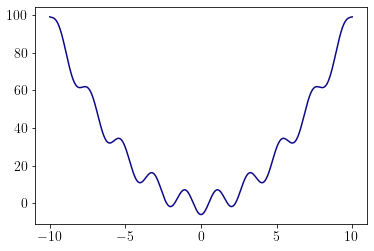

In [20]:
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, f(xx))

In [21]:
plt.rcParams.update(orig_plt_rcParams)

In [22]:
set_cmap_cycler(4)

`begin local_minima2`

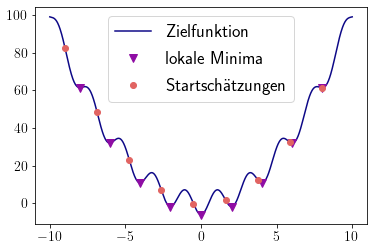

In [23]:
xx = np.linspace(-10, 10, 1000)  # allgem. Auswertestellen
xx_start = np.linspace(-9, 8, 9) # Startschätzungen
yy_start = f(xx_start)

plt.plot(xx, f(xx), label="Zielfunktion")
xx_res = np.zeros(len(xx_start))
for i, x_start in enumerate(xx_start):
    xx_res[i] = minimize(f, x0=x_start).x

plt.plot(xx_res, f(xx_res), "v", ms=8, label="lokale Minima")
plt.plot(xx_start, f(xx_start), "o", label="Startschätzungen")
plt.legend() #!
show_book("lokale_minima") #!

`end local_minima2`

In [24]:
set_cmap_cycler(1)

`begin local_minima3`

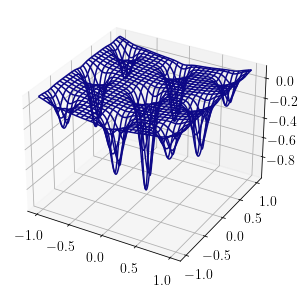

In [25]:
def f(xx):
    # Gaußsche Glocke als Hüllkurve
    hull = np.exp(-(xx[0]**2+ xx[1]**2))
    return 0.1*xx[0]**2 - hull*\
           np.exp(-5*(np.sin(4*xx[0])**2 + np.sin(4*xx[1])**2))

N = 2000
xxN = np.linspace(-1, 1, N)
yyN = np.linspace(-1, 1, N)

XX, YY = np.meshgrid(xxN, yyN)
ZZ = f((XX, YY))

# 1. Grafik
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(XX, YY, ZZ, rstride=70, cstride=70)
plt.savefig("lokale_minima_2d_wireframe.pdf") #!
show_book("lokale_minima_2d_wireframe") #!

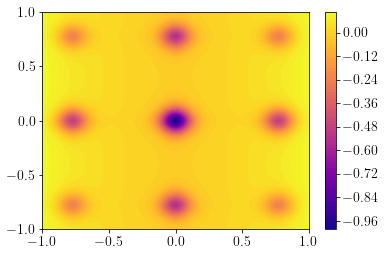

In [26]:

# 2. Grafik
plt.figure()
plt.contourf(XX, YY, ZZ, 100, cmap="plasma")
plt.colorbar()
# aus Qualitätsgründen als PNG-Datei speichern #!
show_book("lokale_minima_2d_contour", png=True, dpi=300) #!

`end local_minima3`

In [27]:
# Überflüssige Ränder berschneiden (nur relevant fürs Buch)
# !pdfcrop lokale_minima_2d_wireframe_snip.pdf
# !pdfcrop lokale_minima_2d_wireframe_color_snip.pdf

`begin local_minima4`

In [28]:
# Hintergrundbild: Farbkarte
#!plt.contourf(XX, YY, ZZ, 100, cmap="plasma")

# Gitter mit Startwerten generieren
M = 4
uu = np.linspace(-.9, .9, M)
vv = np.linspace(-.9, .85, M)
UU, VV = np.meshgrid(uu, vv)
UU.shape

(4, 4)

In [29]:
VV.shape

(4, 4)

In [30]:
# Gitterpunkte plotten
#!plt.scatter(UU, VV, zorder=3)

# zusammengehörende Paare erzeugen
uv = np.column_stack((UU.flatten(), VV.flatten()))
uv.shape

(16, 2)

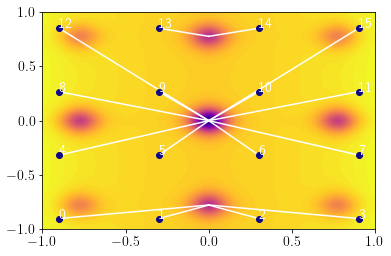

In [31]:
# contour und scatter wegen Zellaufteilung in dieser Zelle wiederholen #!
plt.contourf(XX, YY, ZZ, 100, cmap="plasma") #!
plt.scatter(UU, VV, zorder=3) #!

# Schleife: Minimierung mit Startschätzung aus Gitter
for i, uv0 in enumerate(uv):
    res = minimize(f, x0=uv0).x
    
    # Startwert und Ergebnis als weiße Linie
    ww = np.column_stack((uv0, res))
    plt.plot(ww[0, :], ww[1, :], "-", color="white")
    
    # Knotennummer eintragen
    plt.text(ww[0, 0], ww[1, 0], str(i), color="white")
# #!
show_book("lokale_minima_2d_grid_results", png=True, dpi=300) #!

`end local_minima4`

### Nebenbedingungen und Randbedingungen (Beispiel: Optimalsteuerung)

`begin optimal_control1`

In [32]:
import sympy as sp

xx0 = sp.Matrix([0, 0]) # Anfangszustand
z_Ziel = 5 # gewünschte Endposition
T_end = 10.0
N = 30
tau = T_end/N

w = sp.Symbol("w")
# Symbole für a1, ..., a30 erzeugen
aa = sp.symbols(f"a1:{N+1}")

# Modellgleichungen
def rhs(xx, a):
    return sp.Matrix([xx[0] + xx[1]*tau,
                      xx[1] + a*tau])

`end optimal_control1`

`begin optimal_control2`

In [33]:
XX = [] # Liste für Zwischenzustände
xx_last = xx0  # "letzter Zustand"
J = 0 # Initialisierung der Kostenfunktion

for a in aa:
    # Folgezustand berechnen
    xx_new = rhs(xx_last, a)
    XX.append(xx_new)
    
    # Beitrag zur Kostenfunktion
    J += (xx_new[0] - z_Ziel)**2 + a**2*w
    
    xx_last = xx_new

`end optimal_control2`

`begin optimal_control3`

In [34]:
# Liste -> 2 x N Matrix mit Zuständen:
# hstack steht für "horizontaler Stapel" und ist das
# SymPy-Pendant zu np.row_stack
XX = sp.Matrix.hstack(*XX)

# Ausdrücke in Funktion umwandeln:
XX_func = sp.lambdify(aa, XX)  
J_func_0 = sp.lambdify(aa+(w,), J)

# Aufrufsignatur der Zielfunktion anpassen 
def J_func(aa_array, w_num):
    return J_func_0(*aa_array, w_num)

`end optimal_control3`

In [35]:
plt.rcParams.update(double_plt_rcParams)

In [36]:
set_cmap_cycler(5)

`begin optimal_control4`

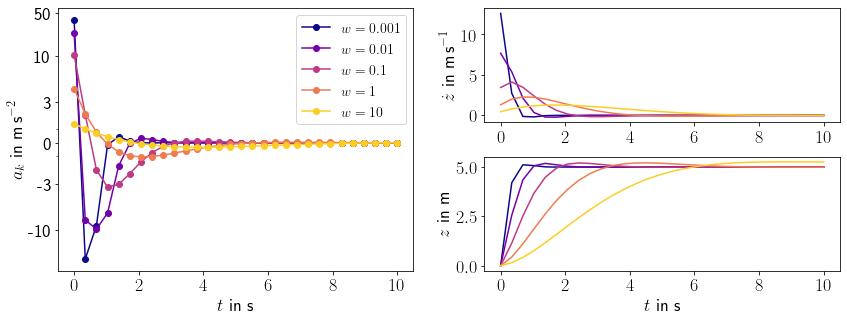

In [37]:
tt = np.linspace(0, T_end, N)
a_max_values = []
# #!
plt.figure(figsize=(12, 5)) #!
ax1 = plt.subplot(2, 2, (1, 3)) #!
ax2 = plt.subplot(2, 2, 2) #!
ax3 = plt.subplot(2, 2, 4) #!
# (Erzeugen von Achsen-Objekten ax1, ax2, ax3 ausgeblendet)
# #!
for w_num in [1e-3, 0.01, 0.1, 1, 10]:
    res = minimize(J_func, np.ones(N), args=(w_num,))
    assert res.success
    a_max_values.append(max(res.x)) # Maximalwert speichern
    
    ax1.plot(tt, res.x, 'o-', label=f"$w={w_num}$")

    XX_num = XX_func(*res.x) # z und z_dot aus a_k berechnen

    ax2.plot(tt, XX_num[1, :])
    ax3.plot(tt, XX_num[0, :])

# Für Erkennbarkeit kleiner Werte: nichtlineare Skalierung
ax1.set_yscale("symlog", linthresh=5)
# #!
ax1.legend(loc="upper right", fontsize=14) #!
# #!
# (Code für Legende und Beschriftung ausgeblendet ...)
ax1.set_yticks([-10, -3, 0, 3, 10, 50]) #!
ax1.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:3.0f}")) #!
#  #!
ax1.set_ylabel("$a_k$ in m\,s${}^{-2}$") #!
ax2.set_ylabel(r"$\dot z$ in m\,s${}^{-1}$") #!
ax3.set_ylabel("$z$ in m") #!
ax3.set_yticks([0, 2.5, 5]) #!
#  #!
ax1.set_xlabel("$t$ in s") #!
ax3.set_xlabel("$t$ in s") #!
show_book("optimale_steuerung") #!

`end optimal_control4`

`begin optimal_control5`

In [38]:
# Platzsparende Ausgabe der max-Werte #!
orig_prec = np.get_printoptions() #!
np.set_printoptions(precision=3) #!
np.array(a_max_values)

array([37.83 , 23.035, 10.337,  3.946,  1.383])

`end optimal_control5`

In [39]:
np.set_printoptions(precision=orig_prec)
plt.rcParams.update(orig_plt_rcParams)

In [40]:
set_cmap_cycler(2)

`begin optimale_steuerung_begrenzt1`

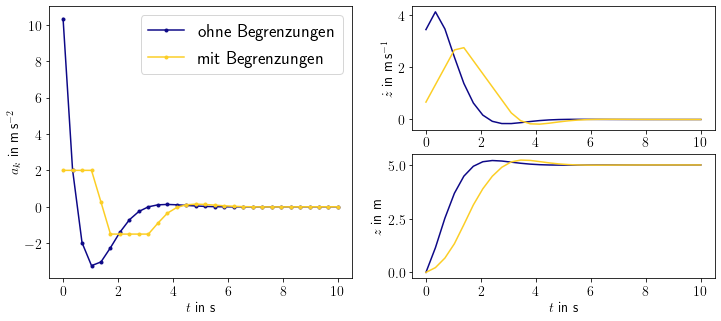

In [41]:
plt.figure(figsize=(12, 5)) #!
ax1 = plt.subplot(2, 2, (1, 3)) #!
ax2 = plt.subplot(2, 2, 2) #!
ax3 = plt.subplot(2, 2, 4) #!
# #!
# Zum Vergleich: Minimierung ohne Grenzen
res1 = minimize(J_func, np.zeros(N), args=(0.1,),)

# Festlegung der Grenzen:
bb = [(-1.5, 2)]*N
# Minimierung mit Grenzen
res2 = minimize(J_func, np.zeros(N), args=(0.1,), bounds=bb)
assert res2.success
assert res1.success
XX_num1 = XX_func(*res1.x)
XX_num2 = XX_func(*res2.x)

# Plotten ... (ausgeblendet)
ax1.plot(tt, res1.x, '.-', label="ohne Begrenzungen") #!
ax1.plot(tt, res2.x, '.-', label="mit Begrenzungen") #!
# #!
ax2.plot(tt, XX_num1[1, :]) #!
ax3.plot(tt, XX_num1[0, :]) #!
ax2.plot(tt, XX_num2[1, :]) #!
ax3.plot(tt, XX_num2[0, :]) #!
# #!
ax1.set_ylabel("$a_k$ in m\,s${}^{-2}$") #!
ax2.set_ylabel(r"$\dot z$ in m\,s${}^{-1}$") #!
ax3.set_ylabel("$z$ in m") #!
ax3.set_yticks([0, 2.5, 5]) #!
#  #!
ax1.set_xlabel("$t$ in s") #!
ax3.set_xlabel("$t$ in s") #!
ax1.legend(loc="upper right") #!
show_book("optimale_steuerung_mit_begrenzung") #!

`end optimale_steuerung_begrenzt1`

`begin optimale_steuerung_nb1`

In [42]:
vmax = 1.5

def constraint_func(aa):
    # Array mit Geschwindigkeiten
    v = XX_func(*aa)[1, :]
        
    # Ungleichung in "größer-0-Form":
    # v < vmax   -->  vmax - v > 0
    return vmax - v

constraint_list = [{"type": "ineq", "fun": constraint_func}]

[{'type': 'ineq', 'fun': <function __main__.constraint_func(aa)>}]

`end optimale_steuerung_nb1`

`begin optimale_steuerung_nb2`

In [43]:
# Minimierung mit Grenzen und Nebenbedingungen
res3 = minimize(J_func, np.zeros(N), args=(0.1,),
                bounds=bb, constraints=constraint_list)
assert res3.success
# Plotten ausgeblendet ...
fname = "optimale_steuerung_mit_nb" #!
show_book(fname, saveandshow=False) #!

`end optimale_steuerung_nb2`

In [44]:
set_cmap_cycler(3)

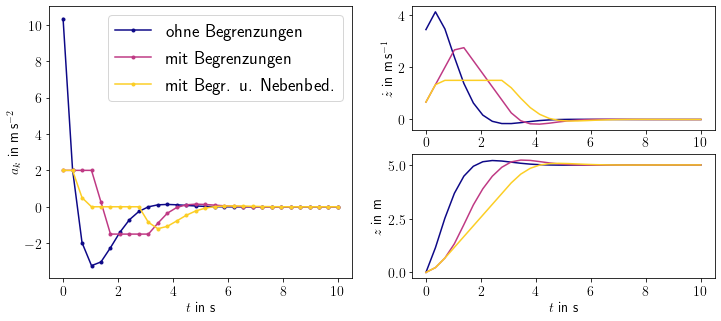

In [45]:
plt.figure(figsize=(12, 5)) #!
ax1 = plt.subplot(2, 2, (1, 3)) #!
ax2 = plt.subplot(2, 2, 2) #!
ax3 = plt.subplot(2, 2, 4) #!
# #!
# Zum Vergleich: Bisherige Ergebnisse #!
res1 = minimize(J_func, np.zeros(N), args=(0.1,),) #!
bb = [(-1.5, 2)]*N #!
res2 = minimize(J_func, np.zeros(N), args=(0.1,), bounds=bb)
assert res1.success #!
assert res2.success #!
# !

c1 = {"color": "0.7"}
c2 = {"color": "0.5"}
c3 = {"color": "0.3"}


XX_num1 = XX_func(*res1.x)
XX_num2 = XX_func(*res2.x)
XX_num3 = XX_func(*res3.x)

ax1.plot(tt, res1.x, '.-', label="ohne Begrenzungen") #!
ax1.plot(tt, res2.x, '.-', label="mit Begrenzungen") #!
ax1.plot(tt, res3.x, '.-', label="mit Begr. u. Nebenbed.") #!
# #!
ax2.plot(tt, XX_num1[1, :]) #!
ax3.plot(tt, XX_num1[0, :]) #!
ax2.plot(tt, XX_num2[1, :]) #!
ax3.plot(tt, XX_num2[0, :]) #!
ax2.plot(tt, XX_num3[1, :]) #!
ax3.plot(tt, XX_num3[0, :]) #!
# #!
ax1.set_ylabel("$a_k$ in m\,s${}^{-2}$") #!
ax2.set_ylabel(r"$\dot z$ in m\,s${}^{-1}$") #!
ax3.set_ylabel("$z$ in m") #!
ax3.set_yticks([0, 2.5, 5]) #!
#  #!
ax1.set_xlabel("$t$ in s") #!
ax3.set_xlabel("$t$ in s") #!
ax1.legend(loc="upper right") #!
show_book(fname, saveandshow=True) #!

In [46]:
print("#"*68)

####################################################################


## Funktionsapproximation

In [47]:
# orig_prec = np.get_printoptions() #!
np.set_printoptions(precision=8) #!

In [48]:
np.random.seed(952) # für Reproduzierbarkeit
uu = np.array([1, 5, 10, 12, 16, 20])
N = len(uu)

R0 = 4.7e1 * 1.03 # mit 3% Abweichung (innerhalb der 10% Toleranz der E12-Reihe)

ii0 = uu/R0
ii1 = np.round(ii0 + np.random.randn(N)*0.05, 3)

print(ii1)

# ausreißer einbauen -> ergibt keine schönen Bilder -> doch
ii1 = np.array([0.008, 0.063, 0.262, 0.21,  0.366, 0.465])


[0.072 0.063 0.262 0.21  0.366 0.465]


array([0.008, 0.063, 0.262, 0.21 , 0.366, 0.465])

In [49]:
tab_data = np.row_stack((np.arange(N)+1, uu, ii1))

try:
    from tabulate import tabulate
    print(tabulate(tab_data, tablefmt="latex", floatfmt="g"))
except ImportError:
    # egal -> nur relevant während des Schreibprozesses des Buches
    pass

\begin{tabular}{rrrrrr}
\hline
 1     & 2     &  3     &  4    &  5     &  6     \\
 1     & 5     & 10     & 12    & 16     & 20     \\
 0.008 & 0.063 &  0.262 &  0.21 &  0.366 &  0.465 \\
\hline
\end{tabular}


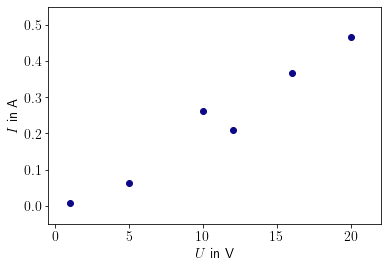

In [50]:
plt.rcParams.update(orig_plt_rcParams)
# plt.rcParams["font.size"] = 20 # weil das Bild neben einer anderen Grafik angezeigt wird

plt.plot(uu, ii1, "o")
plt.xlabel(r"$U$ in V")
plt.ylabel(r"$I$ in A")
plt.axis([-0.5, 22, -0.05, 0.55])

show_book("I_von_U_daten_regression", bbox_inches="tight") #!
# plt.savefig("I_von_U_daten_regression.pdf", bbox_inches="tight")

`begin fit1`

In [51]:
uu = np.array([1, 5, 10, 12, 16, 20])
ii = np.array([0.008, 0.063, 0.262, 0.21,  0.366, 0.465])

# Mittelwert bilden
R_mean = np.mean(uu/ii)

64.40041252032363

`end fit1`

In [52]:
set_cmap_cycler(4)

`begin fit2`

In [53]:
from scipy.optimize import curve_fit

def f_ansatz_i(uu, r):
    # I = U/R
    return uu/r

res, pcov = curve_fit(f_ansatz_i, uu, ii1, p0=1)
res, pcov #!

(array([44.91003445]), array([[6.88807632]]))

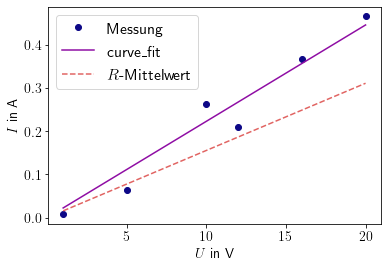

In [54]:

plt.plot(uu, ii, "o", label="Messung")
plt.plot(uu, f_ansatz_i(uu, res), "-", label="curve\_fit")
plt.plot(uu, uu/R_mean, "--", label="$R$-Mittelwert")
plt.legend(fontsize=16) #!
plt.xlabel(r"$U$ in V") #!
plt.ylabel(r"$I$ in A") #!
show_book("I_von_U_regression2") #!

`end fit2`

In [55]:
set_cmap_cycler(3)

`begin fit3`

In [56]:
pp = ii*uu

def f_ansatz_p(uu, r):
    # P = U^2/R
    return uu**2/r

res, pcov = curve_fit(f_ansatz_p, uu, pp, p0=1)
res #!

array([43.89993743])

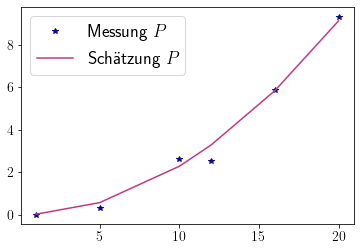

In [57]:
plt.plot(uu, pp, "*", label="Messung $P$")
plt.plot(uu, f_ansatz_p(uu, res), "-", label="Schätzung $P$")
plt.legend() #!
show_book("P_von_U_regression3") #!

`end fit3`

In [58]:
import warnings
from scipy.optimize import OptimizeWarning

In [59]:
# warnings.filters

In [60]:
# Lästige Warnung für das Overfitting-Beispiel verhindern
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [61]:
set_cmap_cycler(3)

`begin fit4`

In [62]:
def f_overfit(uu, *coeffs):
    # Polynomialer Ansatz:
    # P = a0 + a1*U + a2*U^2 + a3*U^3 + ...
    res = 0
    for i, ai in enumerate(coeffs):
        res += ai*uu**i
    return res

init_guess = np.ones(6) # Polynom 5. Grades (6 Koeff.)
res2, pcov = curve_fit(f_overfit, uu, pp, p0=init_guess)

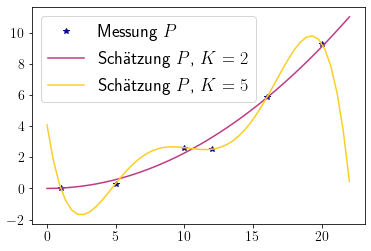

In [63]:
uu2 = np.linspace(0, 22)
plt.plot(uu, pp, "*", label="Messung $P$")
lb = "Schätzung $P$, $K="
plt.plot(uu2, f_ansatz_p(uu2, *res), "-", label=lb + "2$")
plt.plot(uu2, f_overfit(uu2, *res2), "-", label=lb + "5$")
plt.legend() #!
show_book("P_von_U_regression4") #!

`end fit4`

Hinweis: Wenn es nur um das Fitten von Polynomen geht, kann auch die einfachere Funktion *polyfit* (siehe https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) verwendet werden.

In [64]:
set_cmap_cycler(3, start=0.8, end=0)

`begin fit5`

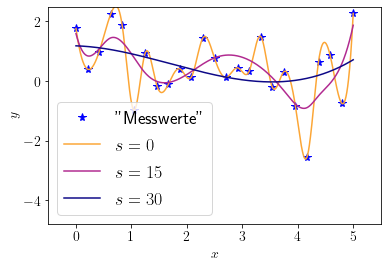

In [65]:
from scipy.interpolate import UnivariateSpline
np.random.seed(0) #!

# Neue "Daten" erzeugen (Rauschen, Mittelwert: 0)
xx = np.linspace(0, 5, 25)
yy = np.random.randn(len(xx)) # Rauschen
plt.plot(xx, yy, '*', ms=8, color="b", label='"Messwerte"')

# höhere x-Auflösung für Spline-Auswertung
xx2 = np.linspace(xx[0], xx[-1], 1000)
for s in [0, 15, 30]:
    spl_func = UnivariateSpline(xx, yy, s=s)
    plt.plot(xx2, spl_func(xx2), label=f"$s={s}$")
##!
plt.legend(loc="lower left") #!
plt.axis([-0.5, 5.5, -4.8, 2.5]) #!
plt.xlabel("$x$") #!
plt.ylabel("$y$") #!
show_book("spline_regression1") #!

`end fit5`